<a href="https://colab.research.google.com/github/virf96/Proyectos/blob/master/Trabajando_con_series_de_tiempo_en_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Relevant Packages

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading and Transforming the Data

In [3]:
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/virf96/curso-series-temporales/master/1.%20Introduccion%20a%20las%20series%20temporales/Python/Index2018.csv")
#Copiamos los datos
df_comp=raw_csv_data.copy()
#Convertimos los datos a formato fecha 
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#Indexamos la fecha
df_comp.set_index("date", inplace=True)
#Indicamos que la frecuencia es business days
df_comp=df_comp.asfreq('b')
#Llenamos missings con método front fill
df_comp=df_comp.fillna(method='ffill')



### Removing Surplus Data

In [4]:
#Creamos la variable market value
df_comp['market_value']=df_comp.spx

In [5]:
df_comp.head()

,spx,dax,ftse,nikkei,market_value
date,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,469.90
1994-01-10,475.27,2225.00,3440.58,18443.44,475.27
1994-01-11,474.13,2228.10,3413.77,18485.25,474.13
1994-01-12,474.17,2182.06,3372.02,18793.88,474.17
1994-01-13,472.47,2142.37,3360.01,18577.26,472.47


In [6]:
#Borramos las variables que no utilizaremos
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
#Indicamos los cortes de la base training y test, sin un proceso aleatorio para no perder le secuencia temporal.
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [7]:
#Tamaño total de la base
len(df_comp)

6277

In [8]:
#80% para el trainning
len(df)

5021

In [9]:
#20% para el test
len(df_test)

1256

**¿Que es el ruido blanco?**

Es un tipo especial de serie temporal donde los datos no siguen ningún patrón

**Satisface 3 condiciones**

$\bullet$ Media Constante

$\bullet$ Varianza Constante

$\bullet$ No tener autocorrelaciones en ningún periodo

In [10]:
#Generamos ruido blanco y almacenamos los valore en "wn" 
#Utilizamos el método "np.random.normal" que nos permite crear una matriz de valores aleatorios de distribución normal
#Para que sea comparable con nuestra serie, le pasamos la media,desviación y la longitud de la variable
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))

In [11]:
#Generamos la nueva variable en el df training
df['wn'] = wn

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1091.051446
std,292.559287,296.689607
min,438.920000,75.872368
25%,914.620000,884.290997
50%,1144.650000,1091.161977
75%,1316.280729,1289.353755
max,1570.252238,2282.276773


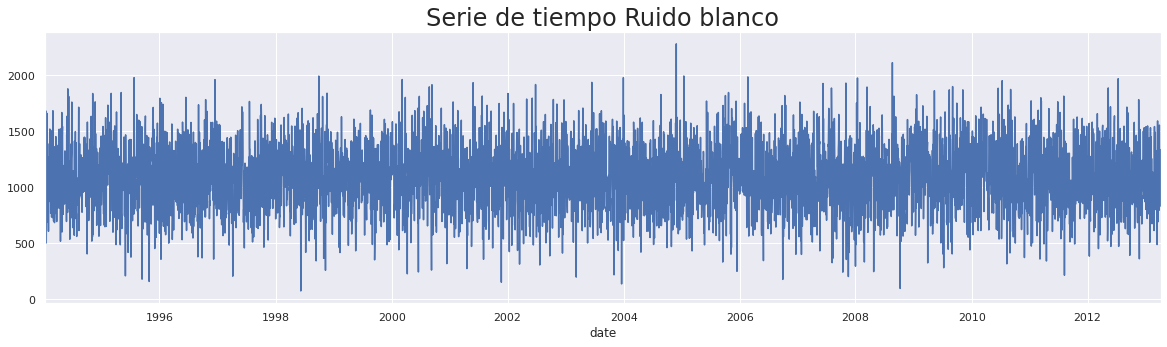

In [13]:
#Gráficamos el ruido blanco que cumple con todos los supuestos de ser un proceso estacionario
df.wn.plot(figsize = (20,5))
plt.title("Serie de tiempo Ruido blanco", size= 24)
plt.show()

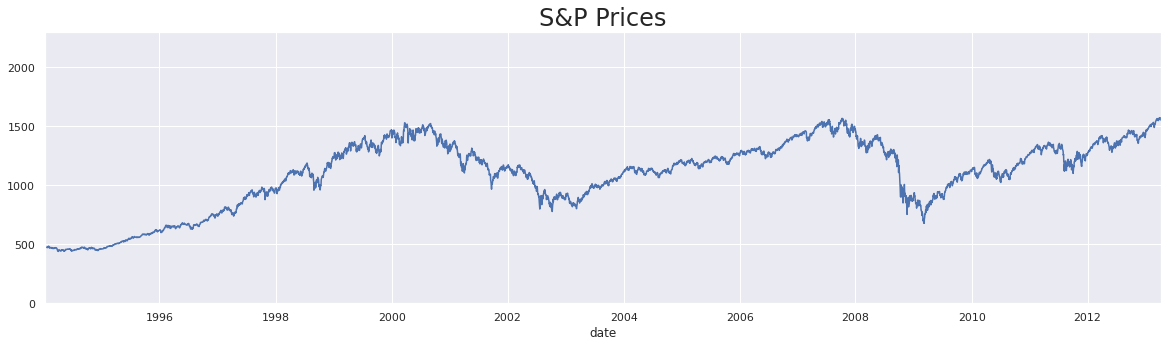

In [14]:
#Variable original
df.market_value.plot(figsize=(20,5))
plt.title("S&P Prices", size = 24)
plt.ylim(0,2300)
plt.show()

**¿Que es una caminata aleatoria?**

Una caminata aleatoria es un tipo especial de series temporal donde los valores tienden a persistir en el tiempo y las diferencias entre períodos son simplemente ruido blanco.

**Satisface lo siguiente**

siendo $P_{t}$ el precio y $\epsilon_t$ los residuos 

**Se cumple lo siguiente**

$P_{t}=P_{t-1}+\epsilon_{t}$ donde $\epsilon_{t}\sim N(\mu,\sigma^{2})$

In [15]:
rw = pd.read_csv("https://raw.githubusercontent.com/virf96/curso-series-temporales/master/3.%20Caracter%C3%ADsticas%20fundamentales/Python/RandWalk.csv")

In [16]:
rw.head()

,date,price
0,07/01/1994,1122.139662
1,08/01/1994,1135.238562
2,09/01/1994,1109.897831
3,10/01/1994,1080.347860
4,11/01/1994,1082.095245


In [17]:
#Convertimos la variable fecha a tipo date time
rw.date = pd.to_datetime(rw.date, dayfirst = True)

In [18]:
#Indexamos la fecha
rw.set_index("date", inplace = True)


In [19]:
rw.head()

,price
date,
1994-01-07,1122.139662
1994-01-08,1135.238562
1994-01-09,1109.897831
1994-01-10,1080.347860
1994-01-11,1082.095245


In [20]:
#Frecuecia de los días business days
rw = rw.asfreq('b')

In [21]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [22]:
#Añadimos la variable "rw.price" al df
df['rw'] = rw.price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
#Ahora ya tenemos en el df: el precio de mercado, ruido blanco y la caminata aleatoria
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1379.583441,1122.139662
1994-01-10,475.27,725.329606,1080.347860
1994-01-11,474.13,1159.284273,1082.095245
1994-01-12,474.17,1536.501998,1083.639265
1994-01-13,472.47,1044.004078,1067.146255


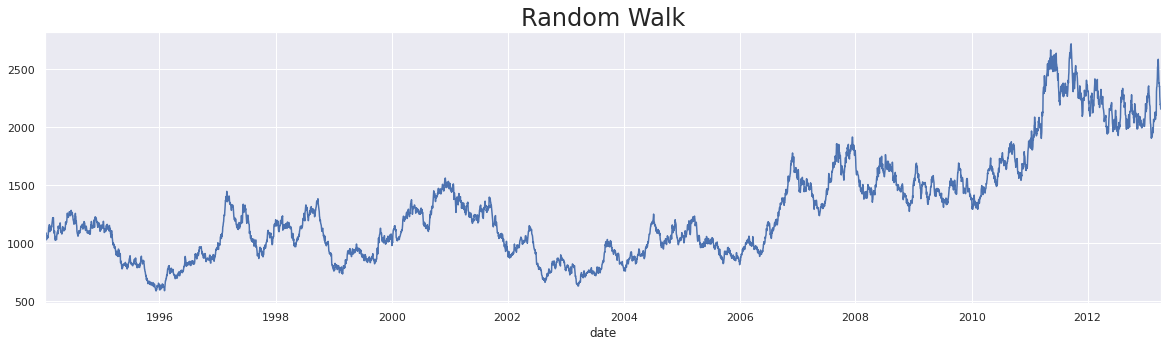

In [24]:
df.rw.plot(figsize = (20,5))
plt.title("Random Walk", size = 24)
plt.show()

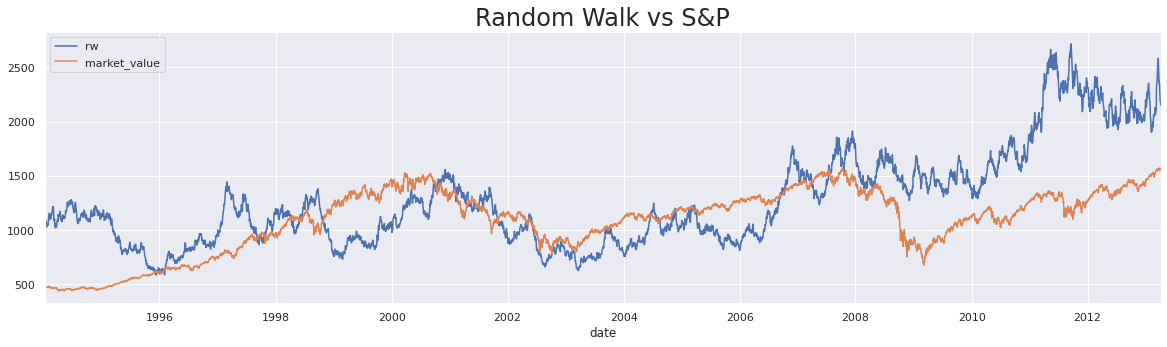

In [25]:
#La caminata aleatoria es un proceso más similar a los precios que el ruido blanco.
df.rw.plot(figsize = (20,5))
df.market_value.plot()
plt.title("Random Walk vs S&P", size = 24)
plt.legend() 
plt.show()

Será de utilidad verificar la **Eficiencia del mercado** para poder verificar que se puede pronosticar adecuadamente.

En general, si una **serie de tiempo** se asemeja a una **caminata aleatoria** los precios no pueden predecirse con gran precisión.

# Series Estacionarias

Una serie es estacionaria cuando es estable en el tiempo, es decir, cuando la **media** ($\mu$) y la **varianza** ($\sigma$) son constantes en el tiempo, y además, no presenta **tendencia**

Además si tomamos 2 intervalos de tiempo iguales de una series de tiempo, las **covarianzas** serán iguales independientemente del punto de partida, en otras palabras tendra **Estacionariedad en covarianza**

**Ejemplo:** 

Sea $S_{1}$,$S_{2}$  $\in$ $T$ donde $T$ es una serie de tiempo estacionaria y $S_{1}$,$S_{2}$ son 2 periodos de tiempo diferentes con misma cardinalidad de $T$, entonces $cov(S_{1})=cov(S_{2})$ 

# Serie No Estacionaria 

La serie no estacionaria es aquella que su **tendencia** y/o **variabilidad** cambian en el tiempo. Los cambios en la **media** determinan una **tendencia** a crecer o decrecer a largo plazo, por lo que no oscilaría alrededor de un valor constante.

<img src="https://estrategiastrading.com/wp-content/uploads/2016/12/media_estacionaria.png">


**Prueba de Dickey-Fuller**

Contraste de hipótesis para series de tiempo:

$H_{0}:$La series no es estacionaria

$H_{1}:$La series es estacionaria

En otras palabras;

Si $H_{0}: \phi_{1} < 1$ (Suponemos que el coeficiente de auto correlación de un retraso es inferior a 1)

Si $H_{1}: \phi_{1} = 1$ (Suponemos que el coeficiente de auto correlación de un retraso es igual a 1)

### cuando el retraso es igual a 1, los períodos están separados solo por 1 periodo de tiempo.

**COEFICIENTE DE AUTO CORRELACIÓN**

Es el coeficiente de correlación entre dos valores o dos momentos en el tiempo en una serie temporal, por lo que la función de auto correlación será $\phi_{k}=corr(x_{t},x_{t-k})$ donde $k$ es el retraso, es decir, el intervalo de tiempo entre los dos períodos.

**Conclusión**

Sea $\lambda_{0}:$ estadístico de contraste

Si, $\lambda_{0}$ < $\lambda_{crit}:$ Rechazamos $H_{0} \Rightarrow$ Serie estacionaria 

Si el valor del estadístico de contraste es menor que el valor crítico rechazamos $H_{0}$ esto implica que la serie será estacionaria

Otro criterio de contraste es el nivel de significancia si
 $p-value<\alpha:$ Rechazamos $H_{0} \Rightarrow$ serie estacionaria

In [26]:
#Utilizamos el método "adfuller"
#El primer valor es el valor del estadístico
#El valor crítico será arrojado para el 99%,90% y 95%
#El p-value es el segundo valor arrojado
#El 3er valor es el número de retrasos

#En este caso el estadístico de la prueba siempre es mayor que los valores críticos par los 3 niveles de confianza por lo que la series no es estacionaria
#Por p-value tenemos que .4 es mayor que .05,.1 y .01 por lo que la serie no es estacionaria
#En este caso tenemos 18 números de retrasos que indica una autocorrelación de 18 periodos atrás,en las series estacionarias este valor no debe ser mayor que cero
sts.adfuller(df.market_value)

(-1.736984745235244,
 0.41216456967706194,
 18,
 5002,
 {'1%': -3.431658008603046,
  '10%': -2.567077669247375,
  '5%': -2.862117998412982},
 39904.880607487445)

In [27]:
#Utilizamos el método "adfuller"
#El primer valor es el valor del estadístico
#El valor crítico será arrojado para el 99%,90% y 95%
#El p-value es el segundo valor arrojado
#El 3er valor es el número de retrasos

#Si comparamos el valor del estadístico con los 3 valores críticos de os 3 niveles de confianza la serie siempre es estacionario
#Por p-value tenemos que es 0 por lo cuál para cualquier nivel de confianza la series es estacionaria
#En este caso tenemos 0 número de retrasos es decir no hay auto correlación
#Concluimos que el ruido blanco es una serie estacionaria
sts.adfuller(df.wn)

(-30.14052561637577,
 0.0,
 5,
 5015,
 {'1%': -3.431654616214729,
  '10%': -2.567076871409699,
  '5%': -2.862116499672828},
 70944.76847831497)

In [28]:
#No es estacionaria la caminata aleatoria
sts.adfuller(df.rw)


(-1.3286073927689708,
 0.6159849181617388,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '10%': -2.567078038881065,
  '5%': -2.8621186927706463},
 46299.333497595144)

### *Estacionalidad*

**Además de las pruebas de hipotesis hay varias formas de comprobar la estacionalidad**

$1.-$ Descomponer la serie de tiempo en 3 efectos

$\bullet$ **Tendencia** (Presencia de un **patrón** consistente en los datos)

$\bullet$ **Estacionalidad** (Efectos **ciclicos** debido a la estacionalidad)

$\bullet$ **Residual** (**Error** de predicción entre los datos reales y los que estamos ajustando)

**Tipos de descomposición**

$1.1.-$ **Descomposición clásica:** con esta esperamos una relación lineal entre las 3 partes y la serie de tiempo observada.

**Enfoques**

$\bullet$ **ADITIVA:** Suponemos que para cualquier período de tiempo el valor observado para la serie temporal es la suma de la **tendencia**, el efecto **estacional** y el efecto **residual** $X_{t}=\mu_{t} + S_{t} + \epsilon_{t}$ para ese periodo

$\bullet$ **MULTIPLICATIVA:** Suponemos que para cualquier período de tiempo el valor observado para la serie temporal es la multiplicación de la **tendencia**, el efecto **estacional** y el efecto **residual** $X_{t}=\mu_{t} * S_{t} * \epsilon_{t}$ para ese periodo

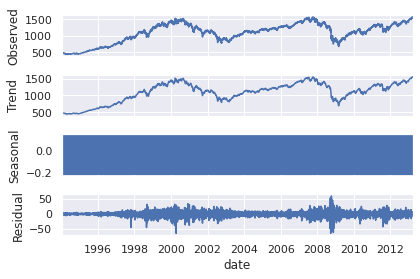

In [29]:
#Método Aditivo
#gráfica 1: Valores observados
#gráfica 2: Tendencia 
#gráfica 3: Estacionalidada (No se observa un patrón ciclico)
#gráfica 4: Residual 
#No se observa estacionalidad
s_dec_additive = seasonal_decompose(df.market_value, model = "additive")
s_dec_additive.plot()
plt.show()

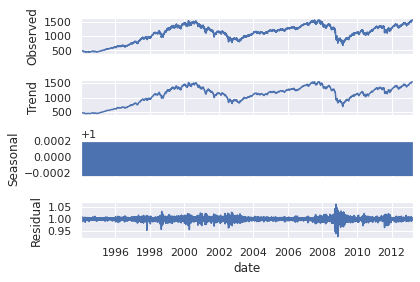

In [30]:
#No se observan patrones claros en la serie de tiempo por cuál conlcluimos que los precios del S&P500 no es una series estacionaria
s_dec_multiplicative = seasonal_decompose(df.market_value, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

### ACF

Correlación entre una secuencia y sí misma.

$corr(x_{t},x_{t-k})$ en donde mide el nivel de semejanza entre los periodos.

El índice $k$, índica el retraso de los períodos, es decir, cuantos de los valores de ayer se parecen a los de hoy.

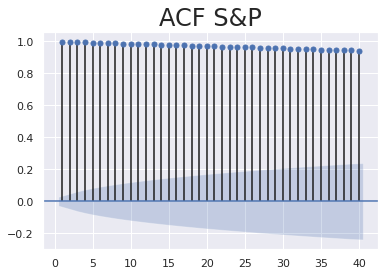

In [31]:
#La función "acf" proporciona la auto correlación para cualquier retraso que consideremos.
#La alternitiva sería la auto-correlación de la serie y multiples retrasos de si misma. 

#Al método le vamos a pasar la variable a analizar y el número de retrasos con "lags", es necesario indicar el número de retraso ya que si no, 
#la función analiza la longitud correspondiente a la serie de tiempo y la práctica indica que es necesario solo analizar los primeros 40 retrasos.
#Indicamos "zero=False" dado que no queremos incluir el valor del periodo actual en el gráfico para el ACF, no tendría sentido.
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title("ACF S&P", size = 24)
plt.show()

#Podemos ver que en el eje de las x, están el número de retrasos 
#En el eje de las y, esta el coeficiente de correlación -1 a 1
#Podemos observar que la parte sombreada en azul representa la significación de los valores de auto correlación, es decir mide si son significativamente
#distintos de cero, lo que sugiere existencia de autocorrelación para ese retraso especifico, en otras palabras que tan bien explican los datos pasados a los
#datos de hoy. 

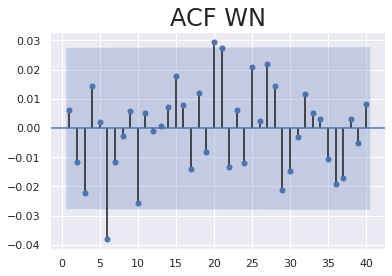

In [32]:
#Ahora analicemos la auto correlación del ruido blanco que generamos.
#Poder distinguir el ruido blanco en los datos de series temporales regulares es fundamental en el modelado
#Tenemos auto correlaciones negativas y positivas, podemos ver que todas líneas caen dentro de la región azul, por lo tanto los coeficientes
#no son significativos en todo el gráfico, es decir son cero,, esto sugiere que no hay auto correlación para ningún retraso (1 supuesto del ruido blanco) 


sgt.plot_acf(df.wn, lags = 40, zero = False)
plt.title("ACF WN", size = 24)
plt.show()

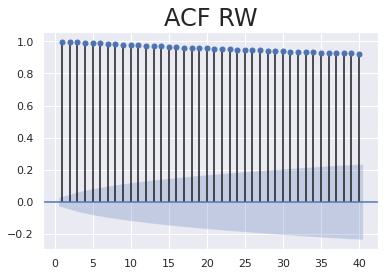

In [33]:
#Como ya habámos visto la caminata es parecido al comportamiento de los precios
sgt.plot_acf(df.rw, lags = 40, zero = False)
plt.title("ACF RW", size = 24)
plt.show()

### PACF

#Auto correlación parcial

Captura formas directas e indirectas en la que la serie retrasada afecta a la original.

Por indirecta nos referimos a todos los canales através de los cuáles los datos del pasado afectan a los datos actuales.

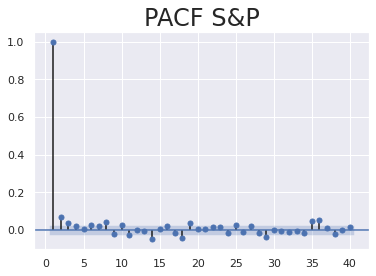

In [34]:
#Utilizamos "plot_pacf" para esta función adicionalemente hay que indicar el método que va a aplicar para indicar la correlación parcial
#En este caso "ols" minimos cuadrados ordinarios

#Podemos observar un área sombreada en azul que es el área de significación, podemos ver que los primeros valores son significativos
#Algunos otros valores son negativos, esto significa que valores de precios más altos hace nueve días resultan en valores más bajos hoy
#El método funciona cancelando todos los valores indirectos que afectan a un valor presente, es decir toma en cuenta los valore intermedios  

sgt.plot_pacf(df.market_value, lags = 40, zero = False, method = ('ols'))
plt.title("PACF S&P", size = 24)
plt.show()

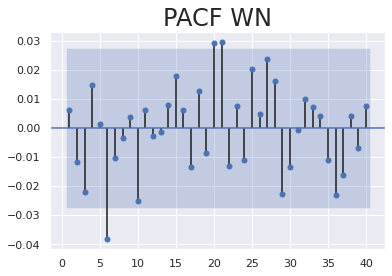

In [35]:
#Para la gráfica de ruido blanco podemos obsrvar que los valores no son significativos, es decir, no hay auto correlación

sgt.plot_pacf(df.wn, lags = 40, zero = False, method = ('ols'))
plt.title("PACF WN", size = 24)
plt.show()

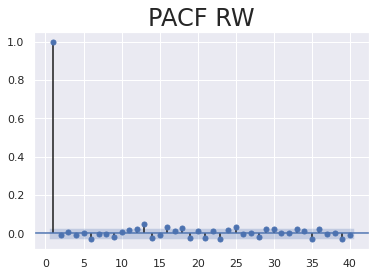

In [36]:
#La caminata aleatoria es parecida a los valores de los precios originales
sgt.plot_pacf(df.rw, lags = 40, zero = False, method = ('ols'))
plt.title("PACF RW", size = 24)
plt.show()